<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/iK9ZtggjJcGKIA)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
#!pip install torchtext
#!pip install matplotlib
#!pip install sklearn

In [2]:
import torch
import torchtext
from torchtext import vocab
from tqdm import tqdm
import os
import pickle
from torch import nn
import time

In [3]:
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#from torch.utils.data import random_split
from sklearn import model_selection
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu

In [4]:
#torch.multiprocessing.set_start_method('spawn')

In [5]:
#from torchtext.data.functional import numericalize_tokens_from_iterator

In [6]:
DATA_PATH = 'data'
#%matplotlib inline

# # For Google Colab only:
# import sys
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
# #from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
# from google.colab import drive
# drive.mount('/content/gdrive')

# DATA_PATH = 'gdrive/My Drive/Colab Notebooks/'

In [7]:
device = 'cuda'

In [8]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [9]:
len(captions)

118287

In [10]:
example = 2000

In [11]:
# captions = captions[:example]
# img_codes = img_codes[:example]

In [12]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:
ВАЖНО! Почему я советую писать отдельную функцию, которая генерирует батч: дело в том, что в датасете для каждой картинки есть несколько (5-7) различных описаний. Когда создаете батч, лучше, чтобы в нем были разные картинки, и к каждой картинке при создании батча выбирать одно из ее описаний рандомно. Это проще реализовать в отдельной функции (но вы, конечно, можете писать код как хотите)
5. Поделить выборку на train/test

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [13]:
from torchtext import vocab

class VocabTorchText():
    '''
    Класс является инструментом по работе со словарем TorchText
    '''
    
    TAG_UNKNOWN = '<unk>'
    TAG_START = '<sos>'
    TAG_END = '<eos>'
    TAG_PAD = '<pad>'
    
    def __init__(self, captions, min_freq=5):
    
        self.vocab = vocab.build_vocab_from_iterator(self._vocab_itrerator(captions), min_freq=min_freq, specials=[self.TAG_PAD, self.TAG_START, self.TAG_END, self.TAG_UNKNOWN])
    
        self.dict_word_to_index = self.vocab.get_stoi()
        self.list_words = self.vocab.get_itos()
    
        self.pad_ix = self.dict_word_to_index[self.TAG_PAD]
        self.unk_ix = self.dict_word_to_index[self.TAG_UNKNOWN]
        self.end_ix = self.dict_word_to_index[self.TAG_END]
        self.start_ix = self.dict_word_to_index[self.TAG_START]
    
    def _vocab_itrerator(self, captions):
        '''
        Данный итератор разбирает последовательность списка спиков, чтобы достать все записи описаний
        '''
        for caption in captions:
            for sentence in caption:
                yield sentence.strip().split()
                
    def sequence_tokens_to_vector(self, sequence_tokens, max_len=None):
        '''
        Функция возвращает вектор предложения по входной последовательности токенов
        Делает это достаточно быстро
        '''
        max_len = max_len or len(sequence_tokens)
        sentence = np.ones(max_len, dtype='int64') * self.pad_ix
        row_ix = [self.dict_word_to_index[word] if word in self.dict_word_to_index.keys() else self.unk_ix for word in sequence_tokens[:max_len]]
        sentence[:len(row_ix)] = row_ix    

        return sentence                
    
    def vector_to_sequence_tokens(self, vector):
        '''
        Преобразует ветор обратно в список токенов
        '''
        sentence = []
        for index in vector:
            sentence.append(self.list_words[index])
        return sentence
    
    def remove_start_tags(self, sequence_tokens):
        result = []
        for token in sequence_tokens:
            if token == self.TAG_UNKNOWN or token == self.TAG_START or token == self.TAG_END or token == self.TAG_PAD:
                pass
            else:
                result.append(token)
        
        return result
    
    def __len__(self):
        return len(self.vocab)
                
vocab_class = VocabTorchText(captions)                

In [14]:
# #Вставляем стартовые и конечные токены, и делаем токенизацию
# for img_i in range(len(captions)):
#     for caption_i in range(len(captions[img_i])):
#         sentence = captions[img_i][caption_i]         
#         sentence = vocab_class.TAG_START+' '+sentence+' '+vocab_class.TAG_END
#         captions[img_i][caption_i] = sentence.split()

In [15]:
msg = captions[0][0].strip().split()
msg

['people', 'shopping', 'in', 'an', 'open', 'market', 'for', 'vegetables', '.']

In [16]:
len(msg)

9

In [17]:
vector = vocab_class.sequence_tokens_to_vector(msg,20)
vector

array([  21, 1027,    9,   16,  134,  491,   81,  211,    5,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [18]:
vector = vocab_class.sequence_tokens_to_vector(msg)
vector

array([  21, 1027,    9,   16,  134,  491,   81,  211,    5])

In [19]:
vocab_class.vector_to_sequence_tokens(vector)

['people', 'shopping', 'in', 'an', 'open', 'market', 'for', 'vegetables', '.']

In [20]:
#Поэкспериментируем со свойствами словаря

In [21]:
vocab_class.vocab.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'vocab': <torchtext._torchtext.Vocab at 0x7f1dacc7cf80>}

In [22]:
len(vocab_class.vocab)

10403

In [23]:
vocab_class.list_words[:10]

['<pad>', '<sos>', '<eos>', '<unk>', 'a', '.', 'on', 'of', 'the', 'in']

In [24]:
#train test split

In [25]:
#captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = model_selection.train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [26]:
#Временно сделаем чтобы train==val. Чтобы модель смогла переобучится
#train_img_codes, val_img_codes, train_captions, val_captions = img_codes, img_codes, captions, captions

In [27]:
del(img_codes)
del(captions)

In [28]:
class CaptionDataset(Dataset):
    '''
    Класс обслуживает torchtext vocab и список списков последовательностей для обработки
    и выдачу их по одному но равномерно
    '''
    
    def __init__(self, vocab, captions, img_codes, sentence_len=20, random_issue=True, split_tokens=True, add_eos=True):
        super().__init__()
        
        self.img_codes = img_codes
        self.vocab = vocab
        self.captions = captions
        self.sentence_len = sentence_len
        
        self.random_issue = random_issue
        self.split_tokens = split_tokens
        self.add_eos = add_eos
        
        self.captions_read_count = [] #Счетчик выдачи описаний, необходим для равномерной выдачи разных названий
        for captions_image in captions:
            self.captions_read_count.append(np.zeros(len(captions_image)))
                
    def __len__(self):
        return len(self.captions)
    
    def _get_sentence_(self, index):
        '''
        Функция выбирает необходимый подиндекс, делая равномерное распределение выдачи разных вариантов
        '''
        captions_image = self.captions[index]
        
        captions_read = self.captions_read_count[index]
        
        min_count = min(captions_read)

        bool_read = (captions_read == min_count) * 1
        
        if self.random_issue:
            sub_index = int(np.random.choice(np.arange(len(captions_read)),size=1, p=bool_read/np.sum(bool_read)))
        else:
            sub_index = int(np.argmax(bool_read))
        
        
        #print('index', index, sub_index)
        
        self.captions_read_count[index][sub_index] += 1

        caption = self.captions[index][sub_index]
        
        if self.add_eos:
            caption = self.vocab.TAG_START+' '+caption+' '+self.vocab.TAG_END
            
        if self.split_tokens:
            caption = caption.split()
        
        sequence_tokens = caption
        
        #print(sequence_tokens)
        
        return self.vocab.sequence_tokens_to_vector(sequence_tokens, self.sentence_len)
    
    def __getitem__(self, index):
        
        dict_result = {}
        dict_result['sentence'] = self._get_sentence_(index)
        
        dict_result['futures'] = self.img_codes[index]
        dict_result['labels'] = index
            
        return dict_result

In [29]:
ds = CaptionDataset(vocab_class, train_captions, train_img_codes, 20, random_issue=True)

In [30]:
#ds.captions

In [31]:
ds[0]

{'sentence': array([   1,   96,   21,    6,   39,   68,  294, 1820,  221,    4, 2690,
         331,    2,    0,    0,    0,    0,    0,    0,    0]),
 'futures': array([0.30702457, 0.33112672, 0.49947745, ..., 0.03013637, 0.29778057,
        0.2297566 ], dtype=float32),
 'labels': 0}

In [32]:
ds.captions_read_count[0]

array([0., 0., 0., 0., 1.])

In [33]:
#ds_m = CaptionDatasetMem(ds, 'data')

In [34]:
#Проверим работу датасета

In [35]:
ds.img_codes[1]

array([0.09798327, 0.11954759, 0.13371491, ..., 0.22059338, 0.43346354,
       0.26252404], dtype=float32)

In [36]:
len(ds)

106458

In [37]:
ds[1]

{'sentence': array([   1,    4,   30,  247, 6618,  178,   88,   94,    8,   54,    2,
           0,    0,    0,    0,    0,    0,    0,    0,    0]),
 'futures': array([0.09798327, 0.11954759, 0.13371491, ..., 0.22059338, 0.43346354,
        0.26252404], dtype=float32),
 'labels': 1}

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [38]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [39]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # [batch size, 1, trg len, trg len]
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [40]:
class MultiHeadAttentionLayerEncoder(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(ENC_HIDDEN, hid_dim)
        self.fc_v = nn.Linear(ENC_HIDDEN, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # [batch size, 1, trg len, trg len]
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [41]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [42]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [43]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        
        #self.transform_encoder = nn.Linear(ENC_HIDDEN, hid_dim)
        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        
        #self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayerEncoder(hid_dim, n_heads, dropout, device)
        
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #enc_src = self.transform_encoder(enc_src_img)
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, None)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [44]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]

        # [batch_size, 1, trg_len, trg_len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, enc_src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        #src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        #enc_src = self.encoder(src)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [45]:
len(vocab_class)

10403

In [46]:
# decoder = CaptionNet(cnn_feature_size=2048, n_tokens=len(vocab_class), emb_size=128, lstm_units=256)

In [47]:
# Model parameters
emb_dim = 128  # dimension of word embeddings
attention_dim = 128  # dimension of attention linear layers
decoder_dim = 128  # dimension of decoder RNN
dropout = 0
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
#cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

In [48]:
OUTPUT_DIM = len(vocab_class)
HID_DIM = 128
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
#ENC_PF_DIM = 128

ENC_HIDDEN = 2048

DEC_PF_DIM = 128
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [49]:
ds[0]['futures']

array([0.30702457, 0.33112672, 0.49947745, ..., 0.03013637, 0.29778057,
       0.2297566 ], dtype=float32)

In [50]:
vocab_class.pad_ix

0

In [51]:
SRC_INPUT = ds[0]['futures']
TRG_PAD_IDX = vocab_class.pad_ix

model = Seq2Seq(None, dec, SRC_INPUT, TRG_PAD_IDX, device).to(device)

In [52]:
model

Seq2Seq(
  (decoder): Decoder(
    (tok_embedding): Embedding(10403, 128)
    (pos_embedding): Embedding(100, 128)
    (layers): ModuleList(
      (0): DecoderLayer(
        (self_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (enc_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=128, out_features=128, bias=True)
          (fc_v): Linear(in_features=128, out_features=128, bias=True)
          (fc_o): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder_attention): MultiHeadAttentionLayerEncoder(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=2048, out_features=

In [53]:
ds.sentence_len

20

In [54]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,658,595 trainable parameters


In [55]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [56]:
model.apply(initialize_weights);

In [57]:
LEARNING_RATE = 5e-4

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [58]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [59]:
from IPython.display import clear_output

In [60]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch['futures'].to(device)
        trg = batch['sentence'].to(device)
        
        optimizer.zero_grad()
        
        #print(trg)
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
    #if (i+1)%10==0:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

    #clear_output(True)
    ax[0].plot(history, label='train loss')
    ax[0].set_xlabel('Batch')
    ax[0].set_title('Train loss')
    if train_history is not None:
        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch')
    if valid_history is not None:
        ax[1].plot(valid_history, label='general valid history')
    plt.legend()

    plt.show()
        
    return epoch_loss / len(iterator)

In [61]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch['futures'].to(device)
            trg = batch['sentence'].to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [62]:
def translate_sentence(enc_src, vocab_class, model, device, max_len = 50):
    
    #model.eval()

    trg_indexes = [vocab_class.start_ix]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src.to(device), trg_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)

        if pred_token == vocab_class.end_ix:
            break
    
    trg_tokens = vocab_class.vector_to_sequence_tokens(trg_indexes)
    trg_tokens = vocab_class.remove_start_tags(trg_tokens)
    
    return trg_tokens

In [63]:
def bleu_evaluate(model, iterator):
    
    model.eval()

    hypotheses = []
    references = []    
    
    with torch.no_grad():
    
        for j, batch in enumerate(iterator):

            src_img = batch['futures'].to(device)
            trg_snt = batch['sentence'].to(device)
            
            batch_size = batch['futures'].shape[0]
            for i in range(batch_size):
                label = batch['labels'][i]
                list_dst_cap = ds_valid.captions[label]
                
                prom = list(map(lambda c: c.split(), list_dst_cap))
                
                references.append(prom)
#                 print('references',prom)

                dst = translate_sentence(src_img[i].squeeze(0), vocab_class, model, device)
                hypotheses.append(dst)
                
#                 print('hypotheses',dst)
            
            
    assert len(references) == len(hypotheses)
    
    bleu4 = corpus_bleu(references, hypotheses)
        
    return bleu4

In [64]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [65]:
ds_train = CaptionDataset(vocab_class, train_captions, train_img_codes, 20, random_issue=True)
len(ds_train)

106458

In [66]:
ds_valid = CaptionDataset(vocab_class, val_captions, val_img_codes, 20, random_issue=False)
len(ds_valid)

11829

In [67]:
model = model.to(device)

In [68]:
batch_size = 128

In [69]:
ds[0]

{'sentence': array([  1,  17, 294,   6,   8,  54, 589, 561, 146,   4, 398,   5,   2,
          0,   0,   0,   0,   0,   0,   0]),
 'futures': array([0.30702457, 0.33112672, 0.49947745, ..., 0.03013637, 0.29778057,
        0.2297566 ], dtype=float32),
 'labels': 0}

In [70]:
def collate_fn_dataloader(batch):
    list_sentence = []
    list_futures = []
    list_labels = []
    for ds_item in batch:
        list_sentence.append(ds_item['sentence'])
        list_futures.append(ds_item['futures'])
        list_labels.append(ds_item['labels'])

    dict_result = {}
        
    list_sentence = np.array(list_sentence)
    list_futures = np.array(list_futures)
        
    dict_result['sentence'] = torch.tensor(list_sentence)
    dict_result['futures'] = torch.tensor(list_futures)
    dict_result['labels'] = torch.tensor(list_labels)
        
    return dict_result

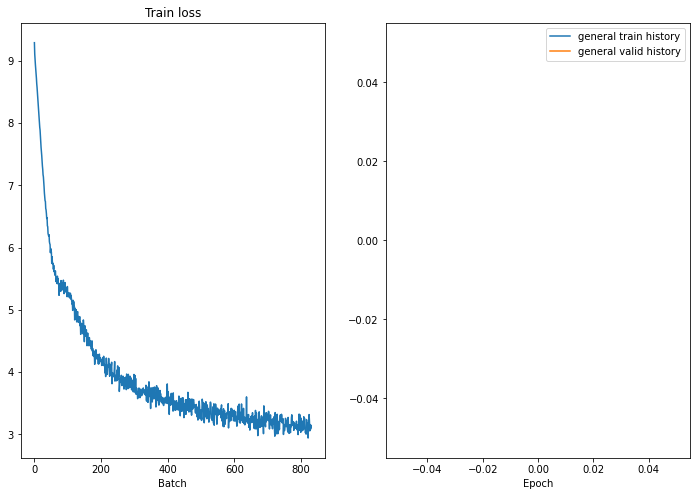

Epoch: 01 | Time: 5m 56s
	Train Loss: 3.956 | Train PPL:  52.256
	 Val. Loss: 2.874 |  Val. PPL:  17.705
bleu4 0.18244156925761265


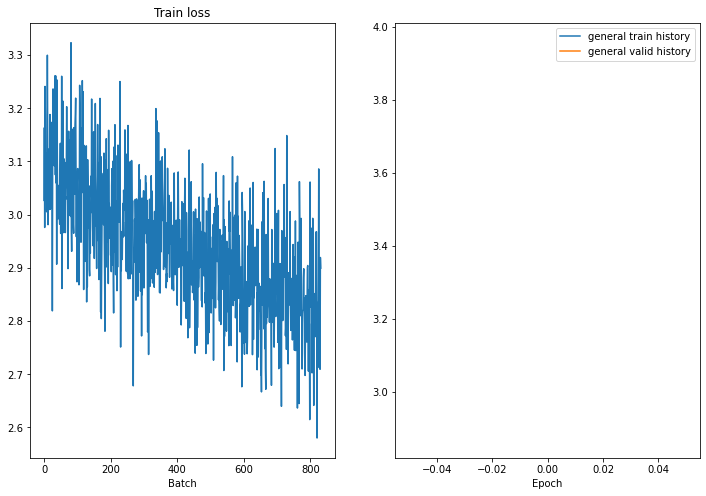

Epoch: 02 | Time: 6m 12s
	Train Loss: 2.940 | Train PPL:  18.920
	 Val. Loss: 2.807 |  Val. PPL:  16.565
bleu4 0.20609566804283266


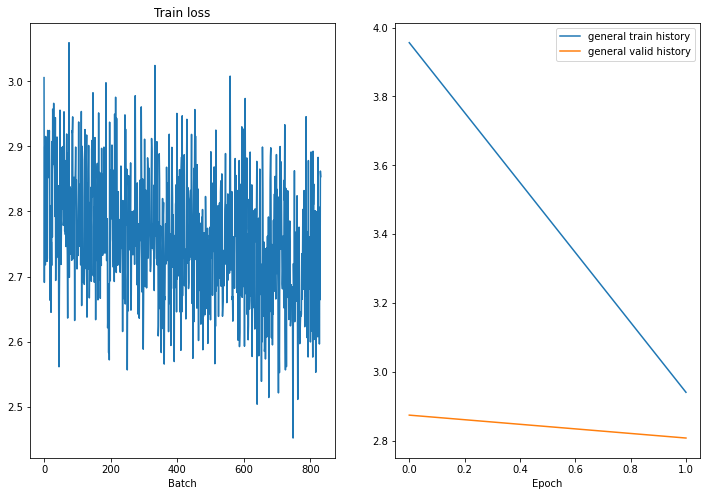

Epoch: 03 | Time: 5m 58s
	Train Loss: 2.757 | Train PPL:  15.757
	 Val. Loss: 2.671 |  Val. PPL:  14.451
bleu4 0.211129382098108


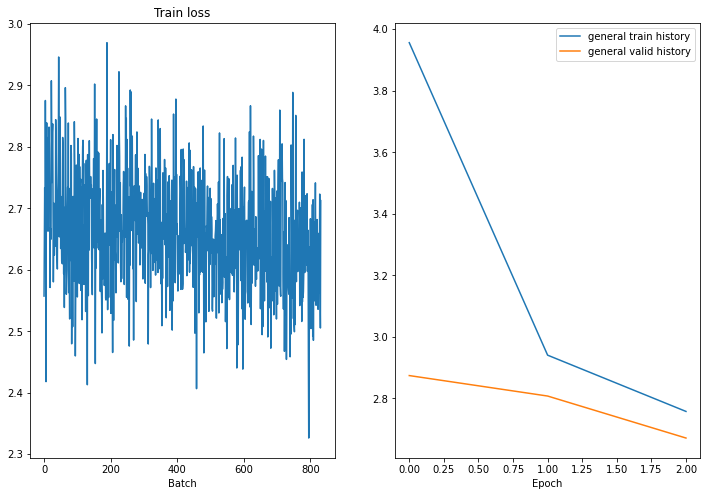

Epoch: 04 | Time: 7m 51s
	Train Loss: 2.661 | Train PPL:  14.313
	 Val. Loss: 2.577 |  Val. PPL:  13.152
bleu4 0.2172330241063985


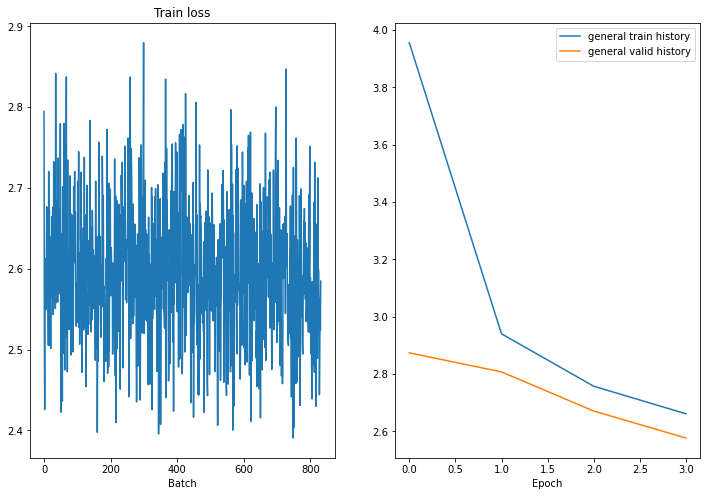

Epoch: 05 | Time: 11m 38s
	Train Loss: 2.593 | Train PPL:  13.376
	 Val. Loss: 2.536 |  Val. PPL:  12.630
bleu4 0.21296417909811896


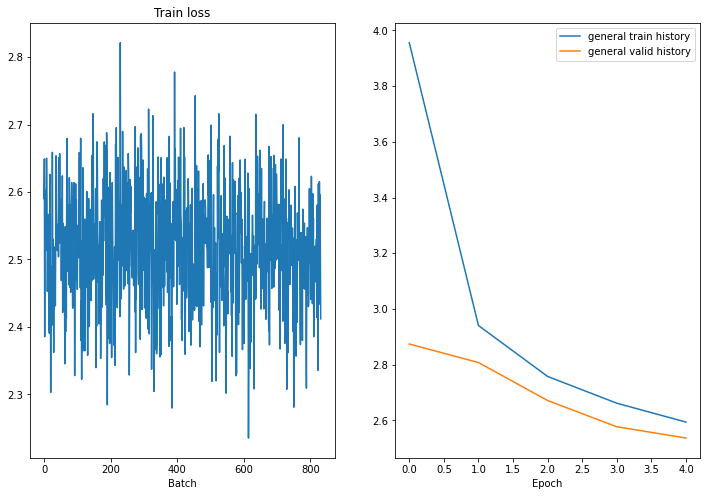

Epoch: 06 | Time: 12m 27s
	Train Loss: 2.517 | Train PPL:  12.388
	 Val. Loss: 2.327 |  Val. PPL:  10.243
bleu4 0.21566423157993855


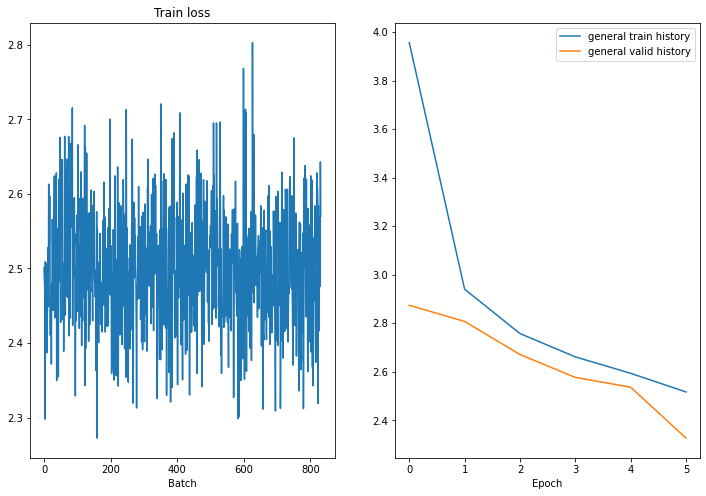

Epoch: 07 | Time: 12m 10s
	Train Loss: 2.498 | Train PPL:  12.155
	 Val. Loss: 2.502 |  Val. PPL:  12.204
bleu4 0.21519626984970158


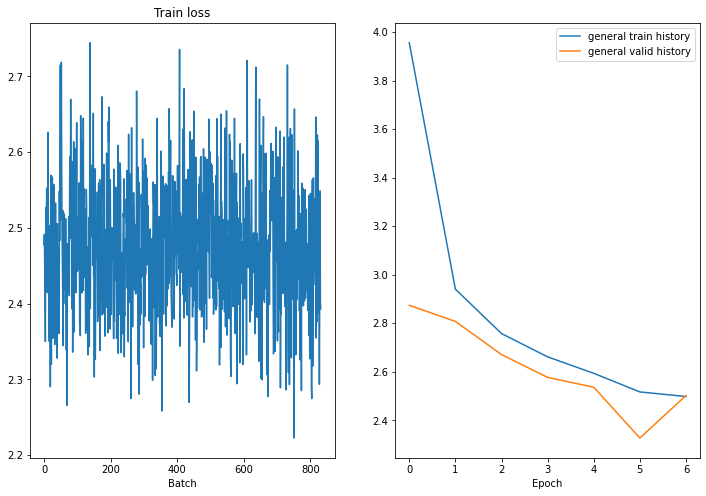

Epoch: 08 | Time: 12m 41s
	Train Loss: 2.476 | Train PPL:  11.895
	 Val. Loss: 2.469 |  Val. PPL:  11.805
bleu4 0.21992273170601825


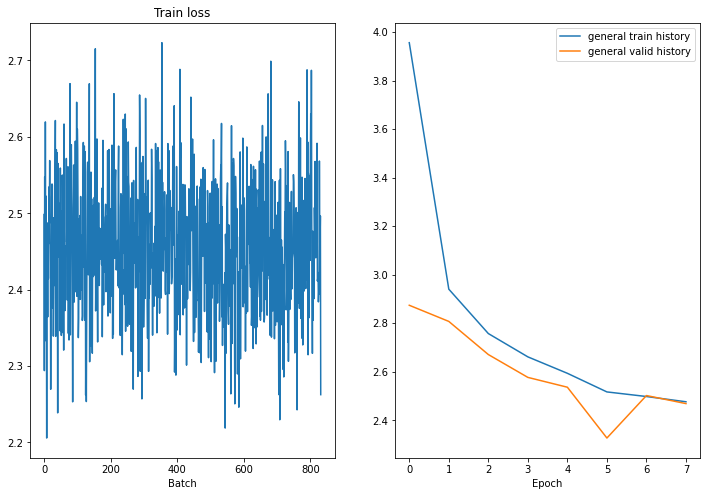

Epoch: 09 | Time: 13m 12s
	Train Loss: 2.455 | Train PPL:  11.651
	 Val. Loss: 2.428 |  Val. PPL:  11.333
bleu4 0.21830155209399105


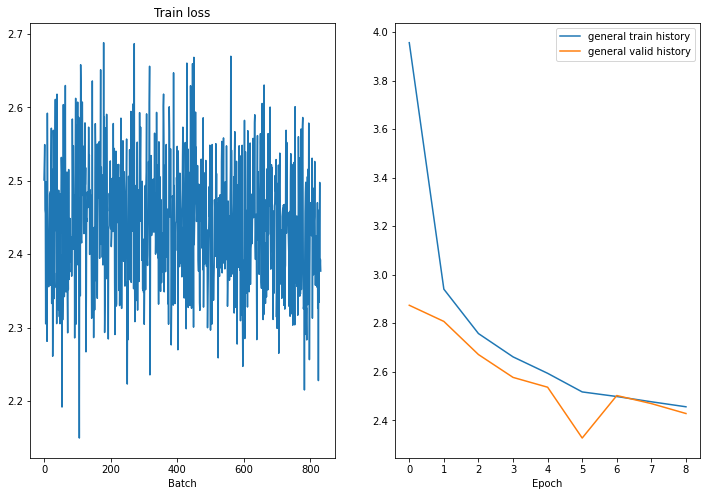

Epoch: 10 | Time: 13m 3s
	Train Loss: 2.441 | Train PPL:  11.487
	 Val. Loss: 2.421 |  Val. PPL:  11.258
bleu4 0.22942226268738544


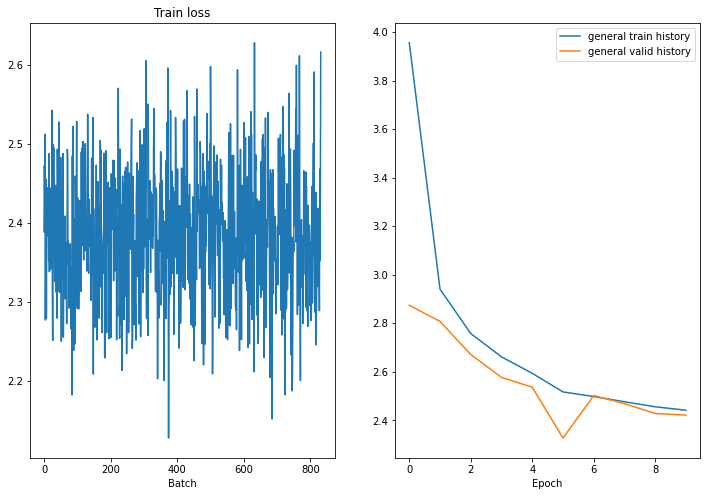

Epoch: 11 | Time: 12m 50s
	Train Loss: 2.385 | Train PPL:  10.855
	 Val. Loss: 2.236 |  Val. PPL:   9.358
bleu4 0.22228790850931204


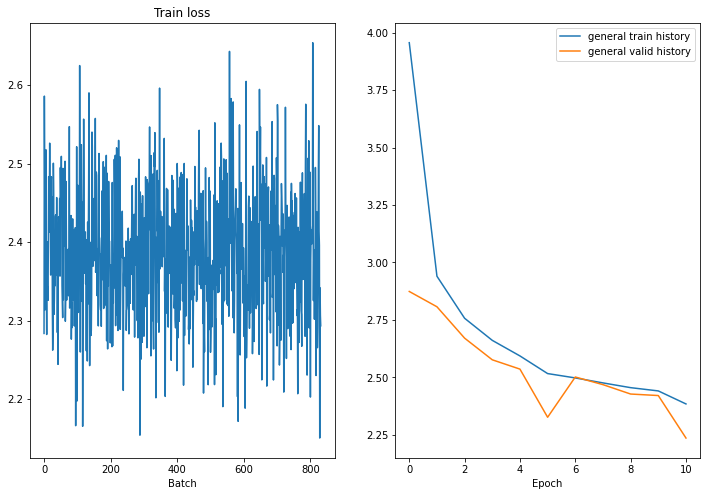

Epoch: 12 | Time: 11m 58s
	Train Loss: 2.386 | Train PPL:  10.866
	 Val. Loss: 2.424 |  Val. PPL:  11.289
bleu4 0.21726301891383723


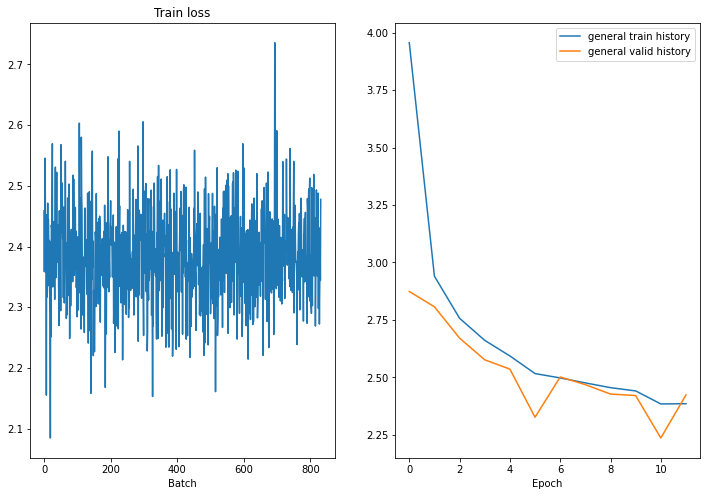

Epoch: 13 | Time: 11m 48s
	Train Loss: 2.383 | Train PPL:  10.841
	 Val. Loss: 2.414 |  Val. PPL:  11.177
bleu4 0.2304973560786182


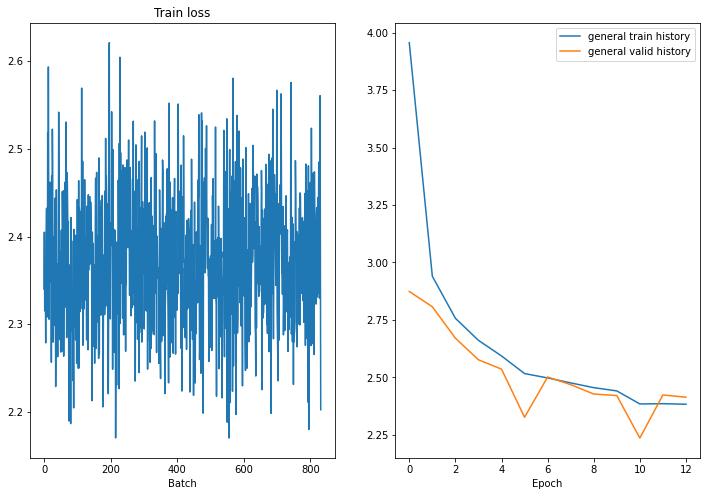

Epoch: 14 | Time: 12m 36s
	Train Loss: 2.372 | Train PPL:  10.722
	 Val. Loss: 2.378 |  Val. PPL:  10.779
bleu4 0.22851104751946416


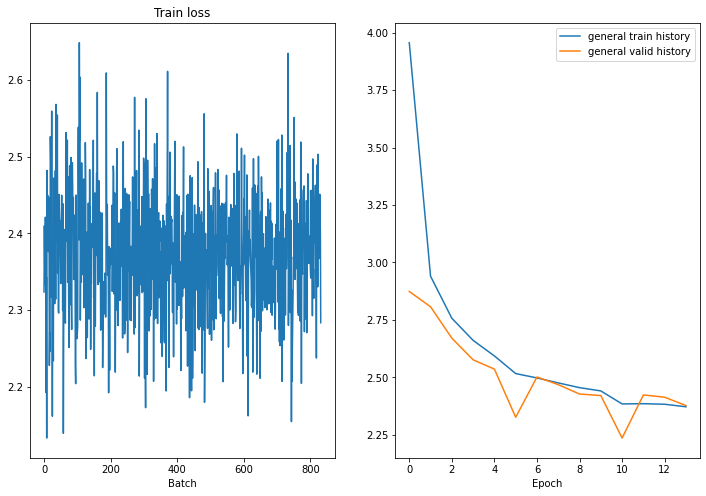

Epoch: 15 | Time: 12m 59s
	Train Loss: 2.371 | Train PPL:  10.706
	 Val. Loss: 2.379 |  Val. PPL:  10.794
bleu4 0.22950700163943283


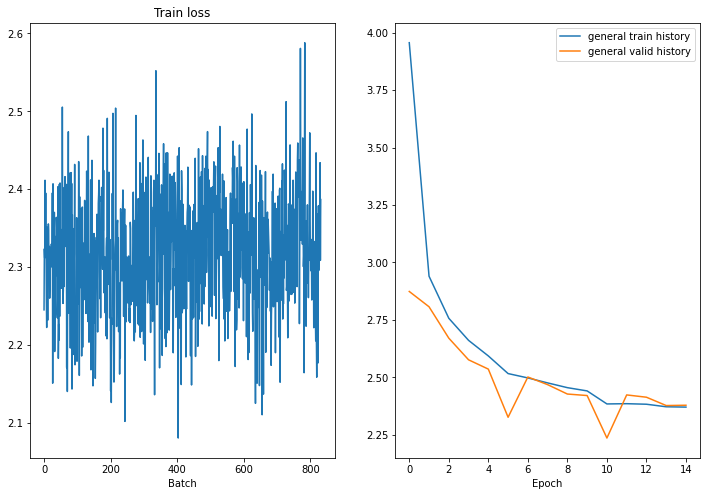

Epoch: 16 | Time: 13m 19s
	Train Loss: 2.319 | Train PPL:  10.165
	 Val. Loss: 2.199 |  Val. PPL:   9.017
bleu4 0.2216997681353554


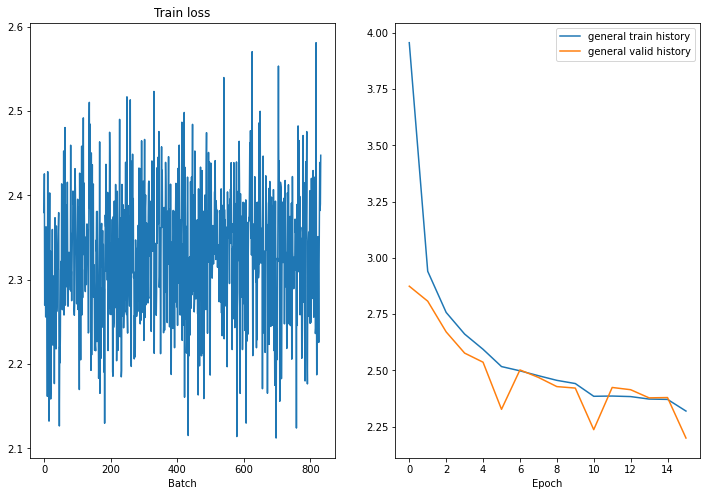

Epoch: 17 | Time: 13m 17s
	Train Loss: 2.328 | Train PPL:  10.253
	 Val. Loss: 2.393 |  Val. PPL:  10.946
bleu4 0.22466437939939807


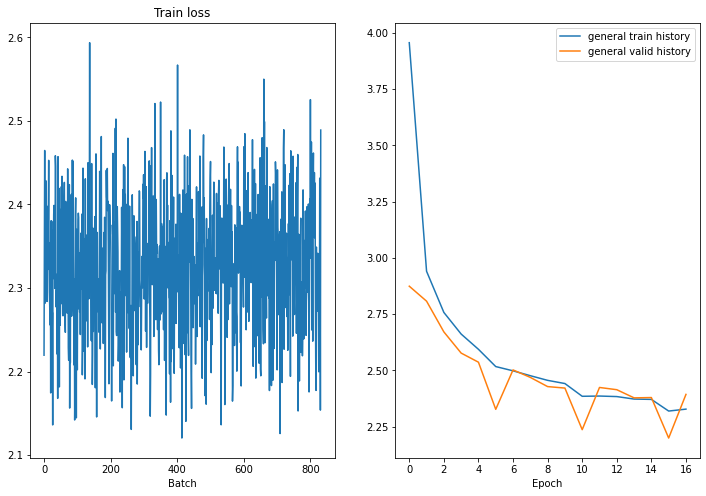

Epoch: 18 | Time: 12m 7s
	Train Loss: 2.327 | Train PPL:  10.243
	 Val. Loss: 2.381 |  Val. PPL:  10.813
bleu4 0.23400468548380926


In [71]:
train_history = []
valid_history = []

N_EPOCHS = 18
CLIP = 1

best_valid_loss = float('inf')

list_bleu4 = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()

    bi_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn_dataloader)
    bi_val = DataLoader(ds_valid, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn_dataloader)
    bi_val2 = DataLoader(ds_valid, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn_dataloader)
    
    train_loss = train(model, bi_train, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, bi_val, criterion)
    
    bleu4 = bleu_evaluate(model, bi_val2)
    
    list_bleu4.append(bleu4)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print('bleu4',bleu4)    

Text(0.5, 1.0, 'bleu4')

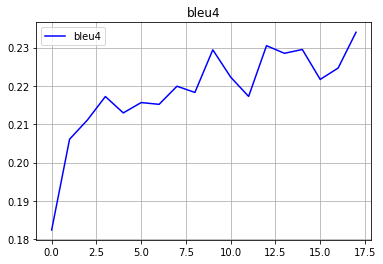

In [72]:
plt.grid(True)
plt.plot(list_bleu4, label='bleu4', color = 'blue')
plt.legend()
plt.title('bleu4')

In [73]:
bi_val = DataLoader(ds_valid, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn_dataloader)

In [74]:
batch = next(iter(bi_val))

In [75]:
enc_src = batch['futures'][0].unsqueeze(0)

In [76]:
result = translate_sentence(enc_src, vocab_class, model, device)

In [77]:
result

['a', 'pizza', 'with', 'tomatoes', ',', 'tomatoes', ',', 'and', 'cheese', '.']

In [78]:
def generate_caption_vectors_neck(model, enc_src, vocab_class, t=1, sample=True, max_len=100):
    
    model.eval()
    
    vocab = vocab_class.list_words
    vocab_indx = list(range(len(vocab)))

    trg_indexes = [vocab_class.start_ix]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        
        #print('trg_tensor',trg_tensor)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        #print('trg_mask',trg_mask)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src.to(device), trg_mask)
        
        next_word_logits = output[0, -1]
        
        next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()
        
        #print(next_word_probs.shape)
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature
        
        if sample:
            #print('next_word_probs', next_word_probs.shape)
            next_word = np.random.choice(vocab_indx, p=next_word_probs) 
        else:
            next_word = np.argmax(next_word_probs)
        
        
#         print(next_word_probs)
        
#         pred_token = output.argmax(2)[:,-1].item()
        
        #print('pred_token',pred_token)
        
        trg_indexes.append(next_word)

        if next_word == vocab_class.end_ix:
            #print('end of seq')
            break
    
    trg_tokens = vocab_class.vector_to_sequence_tokens(trg_indexes)
    trg_tokens = vocab_class.remove_start_tags(trg_tokens)
    
    #trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens

In [79]:
generate_caption_vectors_neck(model, batch['futures'][0].unsqueeze(0), vocab_class, sample=False)

['a', 'pizza', 'with', 'tomatoes', ',', 'tomatoes', ',', 'and', 'cheese', '.']

## Inseption и получение результатов


In [80]:
# загружаем inseption, чтобы можно было прогонять через него новые картинки, 
# получать их эмбеддинги и генерировать описания с помощью нашей сети
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/home/joefox/.pyvenv/diplom-nlp/lib/python3.7/site-packages/torchvision/models/inception.py:83: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


### Сгенерируем описание

In [81]:
list(vocab_class.__dict__)

['vocab',
 'dict_word_to_index',
 'list_words',
 'pad_ix',
 'unk_ix',
 'end_ix',
 'start_ix']

In [82]:
#generate_caption_vectors_neck(decoder, batch['futures'], vocab_class)

In [83]:
def generate_caption(image, decoder, vocab_class, 
                     t, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    caption_prefix = []
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        
        caption_prefix = generate_caption_vectors_neck(decoder, vectors_neck, vocab_class, t, sample, max_len)
        
            
    return caption_prefix

### Скачаем пару картинок, чтобы проверить качество:

In [84]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2022-02-02 17:54:30--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Распознаётся pixel.nymag.com (pixel.nymag.com)… 151.101.112.70
Подключение к pixel.nymag.com (pixel.nymag.com)|151.101.112.70|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [переход]
--2022-02-02 17:54:35--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Распознаётся pyxis.nymag.com (pyxis.nymag.com)… 151.101.114.217
Подключение к pyxis.nymag.com (pyxis.nymag.com)|151.101.114.217|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 54731 (53K) [image/jpeg]
Сохранение в: «img.jpg»

img.jpg             100%[===================>]  53,45K  --.-KB/s    за 0,05s   

2022-02-02 17:54:37 (1,11 MB/s) - «img.jpg» сохранён [54731/54731]



/home/joefox/.pyvenv/diplom-nlp/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  


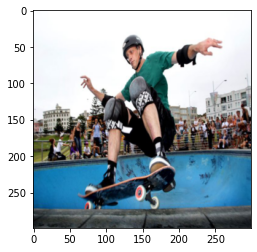

In [85]:
plt.imshow(img)

In [86]:
#translate_sentence(enc_src, trg_field, model, device

In [87]:
for i in range(10):
    print(' '.join(generate_caption(img, model, vocab_class, t=5., sample=True)[1:-1]))

man riding a skateboard on a ramp
man riding a skateboard on a ramp
man is performing a trick on a skateboard
man riding a skateboard on a ramp
person jumping in the air on a skateboard
man jumping in the air on a skateboard
man jumping a skateboard in the air
man on a skateboard on a ramp
man riding a skateboard on a ramp
man doing a trick on a skateboard


--2022-02-02 17:54:39--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Распознаётся ccanimalclinic.com (ccanimalclinic.com)… 162.159.135.42
Подключение к ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 301 Moved Permanently
Адрес: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [переход]
--2022-02-02 17:54:45--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Подключение к ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 106870 (104K) [image/jpeg]
Сохранение в: «img.jpg»

img.jpg             100%[===================>] 104,37K  --.-KB/s    за 0,01s   

2022-02-02 17:54:45 (8,98 MB/s) - «img.jpg» сохранён [106870/106870]



/home/joefox/.pyvenv/diplom-nlp/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


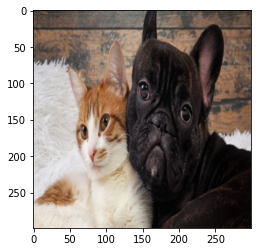

black and white cat is sitting on a couch
black and white cat is sitting on a couch
black and white cat sitting on a couch
black and white cat sitting on a couch
black and white cat sitting on a couch
black and white cat is sitting on a couch
black and white cat sitting on a couch
black and white cat sitting on a couch
close up of a cat laying on a
black and white cat is sitting on a couch


In [88]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, model, vocab_class, t=5.)[1:-1]))

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

In [89]:
# apply your network on images you've found
#
#

## Бонус: Achtung

В качестве бонусного задания предлагается реализовать механизм attention в rnn-сети, которую мы писали в базовой части.